# Processor Analysis

Analysis using the coffea processor class.

Dataset: Muon 2023C data

In [5]:
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt

import hist
import dask
import awkward as ak
import hist.dask as hda
import dask_awkward as dak

from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)
from distributed import Client

# print coffea version
import coffea
print(f"coffea version:")
print(coffea.__version__)

client = Client()

# creates directory if it does not exist
def makeDir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        dataset = events.metadata['dataset']

        # objects

        low_pt_electrons = ak.zip(
            {
                "pt": events.LowPtElectron_pt,
                "eta": events.LowPtElectron_eta,
                "phi": events.LowPtElectron_phi,
                "mass": events.LowPtElectron_mass,
                "charge": events.LowPtElectron_charge,
                "dxy": events.LowPtElectron_dxy,
                "dz": events.LowPtElectron_dz
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        
        electrons = ak.zip(
            {
                "pt": events.Electron_pt,
                "eta": events.Electron_eta,
                "phi": events.Electron_phi,
                "mass": events.Electron_mass,
                "charge": events.Electron_charge,
                "dxy": events.Electron_dxy,
                "dz": events.Electron_dz
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        
        muons = ak.zip(
            {
                "pt": events.Muon_pt,
                "eta": events.Muon_eta,
                "phi": events.Muon_phi,
                "mass": events.Muon_mass,
                "charge": events.Muon_charge,
                "dxy": events.Muon_dxy,
                "dz": events.Muon_dz
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        # histograms

        h_dilowptelectron_mass = (
            hda.Hist.new
            .StrCat(["opposite", "same"], name="sign")
            .Log(1000, 0.2, 200., name="mass", label="$m_{ee}$ [GeV]")
            .Int64()
        )

        h_dielectron_mass = (
            hda.Hist.new
            .StrCat(["opposite", "same"], name="sign")
            .Log(1000, 0.2, 200., name="mass", label="$m_{ee}$ [GeV]")
            .Int64()
        )

        h_dimuon_mass = (
            hda.Hist.new
            .StrCat(["opposite", "same"], name="sign")
            .Log(1000, 0.2, 200., name="mass", label="$m_{\mu\mu}$ [GeV]")
            .Int64()
        )

        # cuts

        # low pt electrons
        
        # Baseline cuts
        # - Standard pT and eta cuts for low pt electrons
        # - Standard dxy cut: abs(dx) < val
        # - Displaced dz cut: abs(dz) >= val
        pt_cut_min  = 1.0
        pt_cut_max  = 10.0
        eta_cut_val = 2.4
        dxy_cut_val = 0.05
        dz_cut_val  = 0.5
        
        baseline_cuts = (
            (low_pt_electrons.pt >= pt_cut_min) &
            (low_pt_electrons.pt < pt_cut_max) &
            (np.abs(low_pt_electrons.eta) < eta_cut_val) &
            (np.abs(low_pt_electrons.dxy) < dxy_cut_val) &
            (np.abs(low_pt_electrons.dz) >= dz_cut_val)
        )
        low_pt_electrons = low_pt_electrons[baseline_cuts]
        
        cut = (
            (ak.num(low_pt_electrons) == 2) &
            (ak.sum(low_pt_electrons.charge, axis=1) == 0)
        )
        # add first and second electron in every event together
        dilowptelectron = low_pt_electrons[cut][:, 0] + low_pt_electrons[cut][:, 1]
        h_dilowptelectron_mass.fill(sign="opposite", mass=dilowptelectron.mass)

        cut = (
            (ak.num(low_pt_electrons) == 2) &
            (ak.sum(low_pt_electrons.charge, axis=1) != 0)
        )
        # add first and second electron in every event together
        dilowptelectron = low_pt_electrons[cut][:, 0] + low_pt_electrons[cut][:, 1]
        h_dilowptelectron_mass.fill(sign="same", mass=dilowptelectron.mass)
        
        # electrons

        cut = (ak.num(electrons) == 2) & (ak.sum(electrons.charge, axis=1) == 0)
        # add first and second electron in every event together
        dielectron = electrons[cut][:, 0] + electrons[cut][:, 1]
        h_dielectron_mass.fill(sign="opposite", mass=dielectron.mass)

        cut = (ak.num(electrons) == 2) & (ak.sum(electrons.charge, axis=1) != 0)
        # add first and second electron in every event together
        dielectron = electrons[cut][:, 0] + electrons[cut][:, 1]
        h_dielectron_mass.fill(sign="same", mass=dielectron.mass)

        # muons

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge, axis=1) == 0)
        # add first and second muon in every event together
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        h_dimuon_mass.fill(sign="opposite", mass=dimuon.mass)

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge, axis=1) != 0)
        # add first and second muon in every event together
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        h_dimuon_mass.fill(sign="same", mass=dimuon.mass)

        return {
            dataset: {
                "n_events": ak.num(events, axis=0),
                "dilowptelectron_mass": h_dilowptelectron_mass,i
                "dielectron_mass": h_dielectron_mass,
                "dimuon_mass": h_dimuon_mass
            }
        }

    def postprocess(self, accumulator):
        pass

coffea version:
2025.1.0


/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Thu/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36053 instead
  warnings.warn(


In [54]:
# Plotting functions

def plotHistogram(histogram, plot_title, y_label, legend_title, plot_dir, plot_name):
    fig, ax = plt.subplots()
    histogram.plot1d(ax=ax)
    ax.set_title(plot_title)
    ax.set_ylabel(y_label)
    ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.legend(title=legend_title, loc='upper right')

    entries_text = getEntriesText(histogram)
    x_limits = ax.get_xlim()
    y_limits = ax.get_ylim()
    text_x = getTextPosition(x_limits, 0.0001)
    text_y = getTextPosition(y_limits, 0.80)
    print("(text_x, text_y) = ({0:.2f}, {1:.2f})".format(text_x, text_y))
    print(entries_text)
    ax.text(text_x, text_y, entries_text)

    savePlot(plot_dir, plot_name)

def getTextPosition(axis_limits, percent):
    axis_min = axis_limits[0]
    axis_max = axis_limits[1]
    axis_length = axis_max - axis_min
    position = axis_min + percent * axis_length
    return position

def getEntriesText(histogram):
    n_entries = histogram.sum()
    entries_text = "n_entries: {0}".format(n_entries)
    return entries_text

def savePlot(plot_dir, plot_name):
    output_png = "{0}/{1}.png".format(plot_dir, plot_name)
    output_pdf = "{0}/{1}.pdf".format(plot_dir, plot_name)
    plt.savefig(output_png, bbox_inches='tight')
    plt.savefig(output_pdf, bbox_inches='tight')


If we were to just use bare uproot to execute this processor, we could do that with the following example, which:

 * Opens a CMS open data file
 * Creates a NanoEvents object using `BaseSchema` (roughly equivalent to the output of `uproot.lazy`)
 * Creates a `MyProcessor` instance
 * Runs the `process()` function, which returns our accumulators


In [6]:
start_time = time.time()

filename = "/eos/user/c/caleb/CMS/datasets/2023_Data/Muon0_Run2023C-22Sep2023_v1-v1_NANOAOD/01e84393-6b2e-4d57-87a4-f71475c051a2.root"
events = NanoEventsFactory.from_root(
    {filename: "Events"},
    steps_per_file=1,
    metadata={"dataset": "Muon_Data"},
    schemaclass=BaseSchema,
).events()
p = MyProcessor()
output_1 = p.process(events)
(computed_1,) = dask.compute(output_1)

n_events = computed_1["Muon_Data"]["n_events"]

end_time = time.time()
run_time_sec = end_time - start_time
run_time_min = run_time_sec / 60

print("computed_1:")
print(computed_1)
print("number of events: {0}".format(n_events))
print("run time: {0:.2f} seconds = {1:.2f} minutes".format(run_time_sec, run_time_min))

/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Thu/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


computed_1:
{'Muon_Data': {'n_events': 1032791, 'dilowptelectron_mass': Hist(
  StrCategory(['opposite', 'same'], name='sign'),
  Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{ee}$ [GeV]'),
  storage=Int64()) # Sum: 20862.0 (21385.0 with flow), 'dielectron_mass': Hist(
  StrCategory(['opposite', 'same'], name='sign'),
  Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{ee}$ [GeV]'),
  storage=Int64()) # Sum: 30308.0 (31081.0 with flow), 'dimuon_mass': Hist(
  StrCategory(['opposite', 'same'], name='sign'),
  Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Int64()) # Sum: 316069.0 (319246.0 with flow)}}
number of events: 1032791
run time: 14.51 seconds = 0.24 minutes


n_entries: 20862.0
n_entries: 30308.0
n_entries: 316069.0


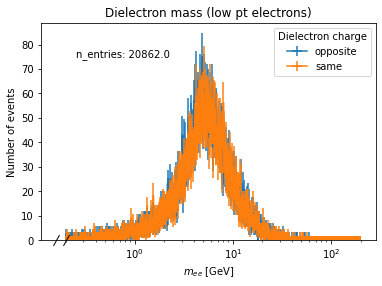

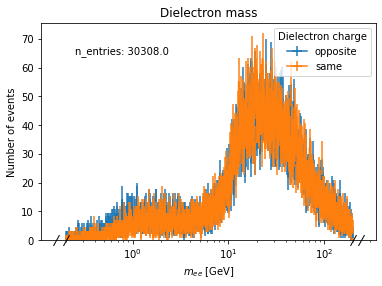

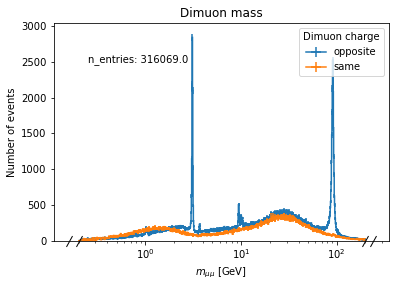

In [44]:
# create directory for plots
plot_dir  = "plots_muon_data"
makeDir(plot_dir)

# create plot
fig, ax = plt.subplots()
computed_1["Muon_Data"]["dilowptelectron_mass"].plot1d(ax=ax)
ax.set_title("Dielectron mass (low pt electrons)")
ax.set_ylabel("Number of events")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(title="Dielectron charge", loc='upper right')
n_entries = computed_1["Muon_Data"]["dilowptelectron_mass"].sum()
print("n_entries: {0}".format(n_entries))
entries_text = "n_entries: {0}".format(n_entries)
ax.text(0.25, 75, entries_text)

# save plot to png and pdf files
plot_name = "dilowptelectron_mass_one_file"
savePlot(plot_dir, plot_name)

# create plot
fig, ax = plt.subplots()
computed_1["Muon_Data"]["dielectron_mass"].plot1d(ax=ax)
ax.set_title("Dielectron mass")
ax.set_ylabel("Number of events")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(title="Dielectron charge", loc='upper right')
n_entries = computed_1["Muon_Data"]["dielectron_mass"].sum()
print("n_entries: {0}".format(n_entries))
entries_text = "n_entries: {0}".format(n_entries)
ax.text(0.25, 65, entries_text)

# save plot to png and pdf files
plot_name = "dielectron_mass_one_file"
savePlot(plot_dir, plot_name)

# create plot
fig, ax = plt.subplots()
computed_1["Muon_Data"]["dimuon_mass"].plot1d(ax=ax)
ax.set_title("Dimuon mass")
ax.set_ylabel("Number of events")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(title="Dimuon charge", loc='upper right')
n_entries = computed_1["Muon_Data"]["dimuon_mass"].sum()
print("n_entries: {0}".format(n_entries))
entries_text = "n_entries: {0}".format(n_entries)
ax.text(0.25, 2500, entries_text)

# save plot to png and pdf files
plot_name = "dimuon_mass_one_file"
savePlot(plot_dir, plot_name)

(text_x, text_y) = (0.14, 71.15)
n_entries: 20862.0
(text_x, text_y) = (0.14, 60.46)
n_entries: 30308.0
(text_x, text_y) = (0.14, 2433.75)
n_entries: 316069.0


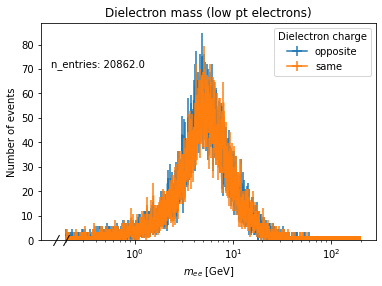

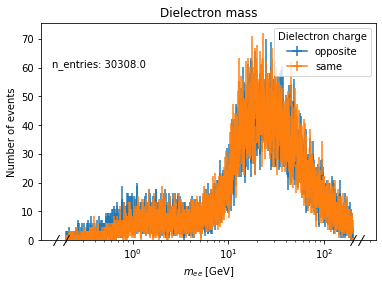

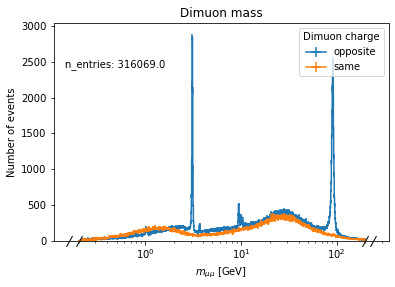

In [55]:
# create directory for plots
plot_dir  = "plots_muon_data"
makeDir(plot_dir)

# plotHistogram(histogram, plot_title, y_label, legend_title, plot_dir, plot_name)

histogram    = computed_1["Muon_Data"]["dilowptelectron_mass"]
plot_title   = "Dielectron mass (low pt electrons)"
y_label      = "Number of events"
legend_title = "Dielectron charge"
plot_name    = "dilowptelectron_mass_one_file"
plotHistogram(histogram, plot_title, y_label, legend_title, plot_dir, plot_name)

histogram    = computed_1["Muon_Data"]["dielectron_mass"]
plot_title   = "Dielectron mass"
y_label      = "Number of events"
legend_title = "Dielectron charge"
plot_name    = "dielectron_mass_one_file"
plotHistogram(histogram, plot_title, y_label, legend_title, plot_dir, plot_name)

histogram    = computed_1["Muon_Data"]["dimuon_mass"]
plot_title   = "Dimuon mass"
y_label      = "Number of events"
legend_title = "Dimuon charge"
plot_name    = "dimuon_mass_one_file"
plotHistogram(histogram, plot_title, y_label, legend_title, plot_dir, plot_name)


One could expand on this code to run over several chunks of the file, setting `entry_start` and `entry_stop` as appropriate. Then, several datasets could be processed by iterating over several files. However, the `dask.compute` and `coffea.dataset_tools` can help with this! We can `preprocess` multiple files and then use our custom `MyProcessor` class to generate the relevant dask task graph. Finally, the result can be obtained by calling `dask.compute`. Since these files are very large, we limit to just reading the first few chunks of events from each dataset with `maxchunks`.

In [4]:
# fileset = {
#     "sample_1": {
#         "files": {
#             "file_1.root": "Events",
#             "file_2.root": "Events"
#         }
#     },
#     "sample_2": {
#         "files": {
#             "file_1": "Events",
#             "file_2": "Events"
#         }
#     }
# }

# load fileset from json file
fileset = None
with open("../json/2023_Data/Muon0_Run2023C-22Sep2023_v1-v1_NANOAOD.json", "r") as my_file:
    fileset = json.load(my_file)

dataset_runnable, dataset_updated = preprocess(
    fileset,
    align_clusters=False,
    step_size=100_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Thu/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [5]:
start_time = time.time()

to_compute = apply_to_fileset(
                MyProcessor(),
                max_chunks(dataset_runnable, 100),
                schemaclass=BaseSchema,
            )
(computed_2,) = dask.compute(to_compute)

n_events = computed_2["Muon_Data"]["Muon_Data"]["n_events"]

end_time = time.time()
run_time_sec = end_time - start_time
run_time_min = run_time_sec / 60

print("computed_2:")
print(computed_2)
print("number of events: {0}".format(n_events))
print("run time: {0:.2f} seconds = {1:.2f} minutes".format(run_time_sec, run_time_min))

computed_2:
{'Muon_Data': {'Muon_Data': {'n_events': 54715896, 'dilowptelectron_mass': Hist(
  StrCategory(['opposite', 'same'], name='sign'),
  Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{ee}$ [GeV]'),
  storage=Int64()) # Sum: 1097608.0 (1126469.0 with flow), 'dielectron_mass': Hist(
  StrCategory(['opposite', 'same'], name='sign'),
  Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{ee}$ [GeV]'),
  storage=Int64()) # Sum: 1534339.0 (1573169.0 with flow), 'dimuon_mass': Hist(
  StrCategory(['opposite', 'same'], name='sign'),
  Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Int64()) # Sum: 16165725.0 (16334984.0 with flow)}}}
number of events: 54715896
run time: 747.99 seconds = 12.47 minutes


The run may depend on how many cores are available on the machine you are running this notebook and your connection to `eospublic.cern.ch`.

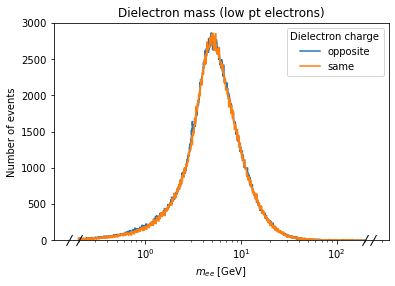

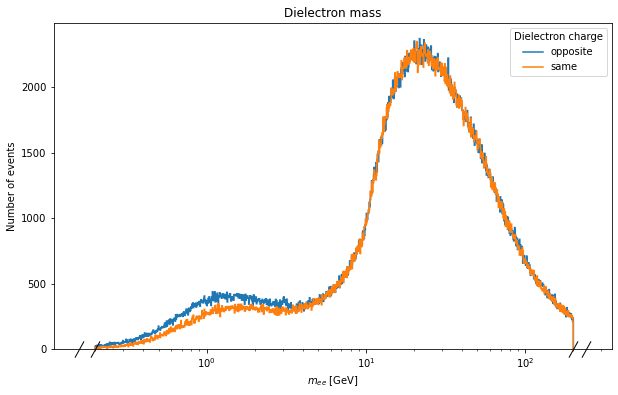

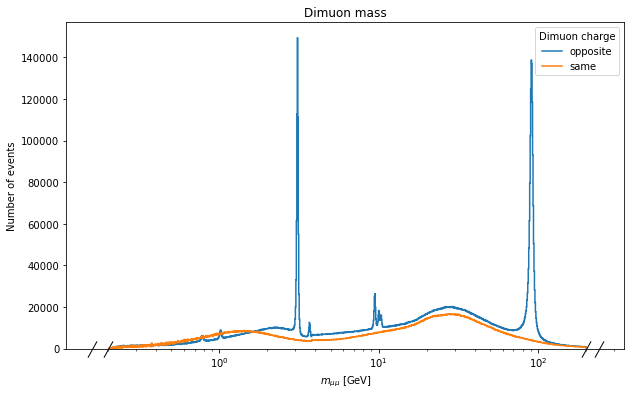

In [6]:
# create plot
fig, ax = plt.subplots()
computed_2["Muon_Data"]["Muon_Data"]["dilowptelectron_mass"].plot1d(ax=ax)
ax.set_title("Dielectron mass (low pt electrons)")
ax.set_ylabel("Number of events")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(title="Dielectron charge")

# save plot to png and pdf files
plot_name = "dilowptelectron_mass_all_files"
savePlot(plot_dir, plot_name)

# create plot
fig, ax = plt.subplots(figsize=(10, 6))
computed_2["Muon_Data"]["Muon_Data"]["dielectron_mass"].plot1d(ax=ax)
ax.set_title("Dielectron mass")
ax.set_ylabel("Number of events")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(title="Dielectron charge")

# save plot to png and pdf files
plot_name = "dielectron_mass_all_files"
savePlot(plot_dir, plot_name)

# create plot
fig, ax = plt.subplots(figsize=(10, 6))
computed_2["Muon_Data"]["Muon_Data"]["dimuon_mass"].plot1d(ax=ax)
ax.set_title("Dimuon mass")
ax.set_ylabel("Number of events")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(title="Dimuon charge")

# save plot to png and pdf files
plot_name = "dimuon_mass_all_files"
savePlot(plot_dir, plot_name)